In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [74]:
data = pd.read_csv("./Wine_Test_02.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1


## Data preprocessing

In [75]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

we can see that there is no null values

In [76]:
data["quality"].value_counts()

quality
1    944
2    159
0     40
Name: count, dtype: int64

here we notice that there is class imbalance

Training with Oversampling minority classes using SMTE algorithm since class imbalance will heavily impact knn performance

In [77]:
def overSample(data: pd.DataFrame):

    X = data.drop('quality', axis=1)
    y = data['quality']

    # training without randomstate to get random samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    return X_res, X_test, y_res, y_test

In [78]:
len(list(range(3, 70, 2)))

34

In [79]:
accuracy = []

for i in range(5):
    iter_accuracy = []
    for j in range(3, 70, 2):
        X_res, X_test, y_res, y_test = overSample(data)
        model = KNeighborsClassifier(n_neighbors=j, metric="euclidean", algorithm="ball_tree").fit(X_res, y_res)
        acc = mean_absolute_error(model.predict(X_test), y_test)
        iter_accuracy.append(acc)
    accuracy.append(iter_accuracy)

accuracy = np.array(accuracy)

In [80]:
avg_accuracy = np.zeros((1, accuracy.shape[1]))
avg_accuracy = np.average(accuracy, axis=0)

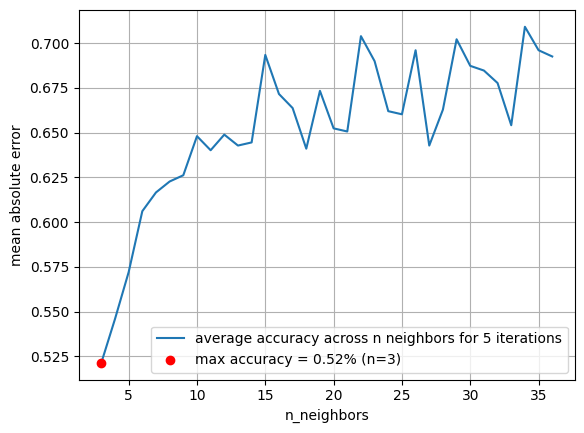

In [95]:
plt.plot(np.array(range(len(avg_accuracy))) + 3, avg_accuracy, label="average accuracy across n neighbors for 5 iterations"),
plt.scatter(np.argmin(np.array(range(len(avg_accuracy)))) + 3, min(avg_accuracy), c="red", zorder=100, label=f"max accuracy = {np.round(min(avg_accuracy), 2)}% (n={np.argmin(np.array(range(len(avg_accuracy)))) + 3})")
plt.xlabel("n_neighbors"), plt.ylabel("mean absolute error")
plt.grid()
plt.legend()

In [103]:
n_value = np.argmin(np.array(range(len(avg_accuracy)))) + 3

accuracy = []

for i in range(5):
    X_res, X_test, y_res, y_test = overSample(data)
    model = KNeighborsClassifier(n_neighbors=n_value, metric="euclidean", algorithm="ball_tree").fit(X_res, y_res)
    acc = mean_absolute_error(model.predict(X_test), y_test)
    accuracy.append(iter_accuracy)

accuracy = np.array(accuracy)
print(f"average accuracy: {round(np.mean(accuracy), 2)}%")

average accuracy: 0.66%


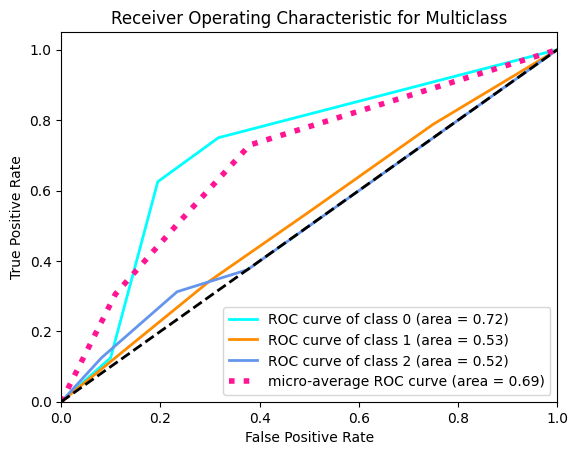

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE

data = pd.read_csv("./Wine_Test_02.csv")

# Data preprocessing
X = data.drop('quality', axis=1)
y = data['quality']
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, stratify=y, test_size=0.2)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Train KNN with One-vs-Rest
classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3, metric="euclidean", algorithm="ball_tree"))
classifier.fit(X_res, y_res)
y_score = classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
lw = 2

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()
